# Modèle `MCLES`

In [17]:
import numpy as np
import pandas as pd

## Chargements des datasets

In [18]:
datasets = []

### dataset multiple features
https://archive.ics.uci.edu/dataset/72/multiple+features

In [19]:
fourier_view = np.loadtxt("../datasets/multiple+features/mfeat-fou")
f_corr_view = np.loadtxt("../datasets/multiple+features/mfeat-fac")
kar_view = np.loadtxt("../datasets/multiple+features/mfeat-kar")
pix_avg_view = np.loadtxt("../datasets/multiple+features/mfeat-pix")
zer_moment = np.loadtxt("../datasets/multiple+features/mfeat-zer")
morphological_view = np.loadtxt("../datasets/multiple+features/mfeat-mor")

X = [fourier_view.T, f_corr_view.T, kar_view.T,
     pix_avg_view.T, zer_moment.T, morphological_view.T]
Y = None

dataset_mf = {"X": X, "Y": Y}
# paramètres par défaut pour le modèle
dataset_mf["parameters"] = {
    "maxIters": 10,
    "alpha": 0.8,
    "beta": 0.4,
    "d": 70,
    "gamma": 0.004,
    "k": 4,
}
dataset_mf["name"] = "multiple_features"
dataset_mf["can_use_exp"] = False

In [20]:
datasets.append(dataset_mf)

### dataset MSRC-v1

https://github.com/ManshengChen/MCLES

In [21]:
from scipy.io import loadmat

dataset_msrc_v1 = loadmat('../datasets/MSRC-v1.mat')
X = []
for x in dataset_msrc_v1["X"][0]:
    X.append(np.array(x.T, dtype=float))
dataset_msrc_v1 = {"X": X, "Y": np.reshape(dataset_msrc_v1["Y"], (dataset_msrc_v1["Y"].shape[0]))}

# paramètres par défaut pour le modèle
dataset_msrc_v1["parameters"] = {
    "maxIters": 10,
    "alpha": 0.8,
    "beta": 0.4,
    "d": 70,
    "gamma": 0.004,
    "k": 4,
}
dataset_msrc_v1["name"] = "MSRC-v1"
dataset_msrc_v1["can_use_exp"] = True

In [22]:
datasets.append(dataset_msrc_v1)

## Métriques

In [23]:
#> information mutuelle normalisé
from sklearn.metrics import normalized_mutual_info_score

#> exactitude
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def accuracy_clustering(labels, labels_clusters):
    cm = confusion_matrix(labels, labels_clusters)
    # on trouve l'allocation idéale en resolvant le problème de maximisation transformé en problème de minimisation
    rowCorrect, ColCorrect = linear_sum_assignment(-np.array(cm))
    cm = cm[:,ColCorrect]
    return np.trace(cm) / np.sum(cm)
    
#> pureté
def purity(labels, labels_clusters):
    cm = confusion_matrix(labels, labels_clusters)
    return np.sum(np.max(cm, axis=0)) / np.sum(cm)


In [24]:
def clusteringMeasure(labels, labels_clusters):
    return {
        "ACC" : accuracy_clustering(labels, labels_clusters),
        "NMI" : normalized_mutual_info_score(labels, labels_clusters),
        "PUR" : purity(labels, labels_clusters),
    }
    

## Implémentations et expérimentations

In [25]:
from sklearn.cluster import KMeans

### Code de référence ( écrit en matlab)
https://github.com/ManshengChen/MCLES

vous devez installé l'outil opensource `octave`, ainsi que son API d'exécution pour python pour pouvoir exécuter le code matlab.

In [16]:
# installation de octave
!apt install octave

E: Impossible d'ouvrir le fichier verrou /var/lib/dpkg/lock-frontend - open (13: Permission non accordée)
E: Impossible d'obtenir le verrou de dpkg (/var/lib/dpkg/lock-frontend). Avez-vous les droits du superutilisateur ?


In [17]:
# installation de l'API
!pip install oct2py

#### Exécution du modèle sur la dataset  `MSRC-v1`

In [26]:
# test d'utilisation de l'API pour exécuter le code matlab
from oct2py import octave

octave.addpath(octave.genpath('./MCLES-master/MCLES Code/'))
y = octave.feval("test.m", [2 , 2])
y

y =

   3   3



array([[3., 3.]])

In [ ]:
# hyper-parametres par défaut
maxIters = 10
alpha = 0.8
beta = 0.4
d = 70
gamma = 0.004

# nombre de clusters
k = 7

# exécution du modèle
W, H, S, F, obj = octave.feval("MCLES.m", dataset_msrc_v1["X"], k, alpha, beta, d, gamma, maxIters)

In [ ]:
P=F
# attribution des observations aux clusters
kmeans = KMeans(
    n_clusters=k,
    n_init='auto'
)
kmeans.fit(P)
labels_clusters = kmeans.labels_

visualisation de la courbe de convergence

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel('Itération')
plt.ylabel('obj')
plt.title(' Convergence')
plt.plot(obj)

visualisation de le carte des poids (pour apprecier la projection dans l'ensemble des clusters)

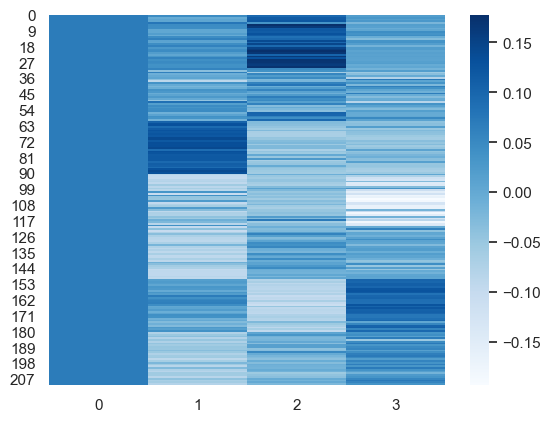

In [ ]:
import seaborn as sns; sns.set()
ax = sns.heatmap(H, cmap="Blues")

cacul des métriques

In [ ]:
clusteringMeasure(dataset_msrc_v1["Y"], labels_clusters)

#### experimentations sur toutes les datasets

In [ ]:
metrics_ref = {"dataset": [], "ACC": [], "NMI": [], "PUR": [], }
for dataset in datasets:
    if dataset["can_use_exp"]:
        print('***** Experimentations sur la dataset {} (en cours)'.format(dataset["name"]))
        
        # recuperation des paramètres pour le modèle
        maxIters = dataset["parameters"]["maxIters"]
        alpha = dataset["parameters"]["alpha"]
        beta = dataset["parameters"]["beta"]
        d = dataset["parameters"]["d"]
        gamma = dataset["parameters"]["gamma"]
        k = dataset["parameters"]["k"]
        
        # execution du modèle en utilisant les paramètres
        _, _, _, P, _ = octave.feval(
            "MCLES.m", dataset["X"], k, alpha, beta, d, gamma, maxIters)
        P = P[0]
        
        # construction des clusters
        kmeans = KMeans(
            n_clusters=k,
            n_init='auto'
        )
        kmeans.fit(P)
        labels_clusters = kmeans.labels_
        
        # calcul des métriques
        result = clusteringMeasure(dataset_msrc_v1["Y"], labels_clusters)
        metrics_ref["dataset"] = dataset["name"]
        metrics_ref["ACC"].append(result["ACC"])
        metrics_ref["NMI"].append(result["NMI"])
        metrics_ref["PUR"].append(result["PUR"])
        print("fin\n")


In [ ]:
metrics_ref = pd.DataFrame(metrics_ref)
metrics_ref.to_json("metrics_ref.json")
metrics_ref

### modèle `MCLES` en python

#### Implémentaion du modèle


In [20]:
!pip install qpsolvers

In [27]:
import numpy as np
from scipy.sparse.linalg import eigs
from scipy import linalg
from sklearn.cluster import KMeans
from sklearn import metrics
from qpsolvers import solve_qp

In [28]:
# fonction de mise à jour de W
def UpdateW(H, X, W, rho=0.8, taux=1, maxIters=99, epsilon=1e-6):
    # rho_init = 1, taux = 1
    # rho_init = 1, taux = 1.1
    # rho_init = 1, taux = 0.9
    # rho_init = 1.2, taux = 0.9
    W_ = np.array(W)
    G = np.array(W)
    T = np.zeros(W.shape, dtype=float)
    d = H.shape[0]
    rho = rho
    prev_obj = None

    A = np.dot(H, H.T) + rho * np.eye(d)
    A = A.T
    for it in range(maxIters):
        error = W_
        # compute W(t+1)
        B = np.dot(X, H.T) + rho * (G - T)
        B = B.T
        W_ = np.linalg.solve(A, B)
        W_ = W_.T
        # compute G(t+1)
        G = W_ + T
        G = (G.T / np.sqrt(np.sum(G**2, axis=1))).T
        # compute T(t+1)
        T += W_ - G
        # update rho
        rho = rho * taux
        error = np.mean(np.mean((W_ - error)**2))
        
        # obj = np.linalg.norm(X - np.dot(W_, H))
        # if it > 0 and abs(obj - prev_obj)/prev_obj < epsilon:
        #     break
        # prev_obj = obj
        
        if it > 0 and error < epsilon:
            break
    return W_


In [29]:
# fonction de mise à jour de H
def UpdateH(X, W, S, alpha):
    # A = np.dot(W.T, W)
    B = np.eye(S.shape[0]) - S
    B = alpha * np.dot(B, B.T)
    # C = np.dot(W.T, X)
    return linalg.solve_sylvester(np.dot(W.T, W), B, np.dot(W.T, X))

In [30]:
# fonction de mise à jour de S
def UpdateS(H, P, alpha=0.001, beta=0.5, gamma=0.004):
    N = H.shape[1]
    bi = np.zeros(N, dtype=float)

    K = np.dot(H.T, H)
    Q = K + (beta/alpha) * np.eye(K.shape[0], dtype=float)
    Q = (Q + Q.T)/2

    # pour les contraintes linéaire
    
    
    A = np.ones((N, N), dtype=float)
    ones = np.ones(N, dtype=float)  # uh , b
    zeros = np.zeros(N, dtype=float)  # lh
    
    S_ = np.zeros((N, N))
    for i in range(N):

        # calcul de bi
        for j in range(N):
            bi[j] = np.linalg.norm(P[i, :] - P[j, :])**2

        # calcul de r
        r = -2*K[i, :] + (gamma / (2*alpha))*bi

        # calcul de S:i
        Si = solve_qp(Q, r, None, None, A, ones, zeros, ones, solver="osqp")
        if Si is not None:
            for j in range(N):
                S_[j][i] = Si[j]
    return S_


In [31]:
def updateP(S,k):
    Z = (S + S.T) / 2
    D = np.diag(np.sum(Z, axis=1))
    L = D - Z
    _, P = eigs(L, k, which='SM')
    return L, P

In [33]:
def MCLES(X, k, d=45, maxIters=30, alpha=0.8, beta=0.5, gamma=0.004, epsilon=0.01, maxItersForKmeans=1000, nInitForKmeans=20, verbose=False):
    # nombre de vues
    V = len(X)
    # nombre d'observations
    N = X[0].shape[1]

    for i in range(V):
        # normalisation de chaque observation (on transforme les vecteurs d'observations en leurs vecteurs unitaires)
        temp = np.sqrt(np.sum(X[i]**2, axis=0))
        X[i] /= temp

    X_ = np.concatenate(X, axis=0)
    D = [X[i].shape[0] for i in range(V)]
    SD = sum(D)
    W = np.zeros((SD, d), dtype=float)
    H = np.random.rand(d, N)
    S = np.zeros((N, N), dtype=float)
    P = np.random.rand(N, k)

    # tableau des valeurs de la fonction objective
    objectives = []

    for it in range(maxIters):
        # > update W
        W = UpdateW(H, X_, W)
        # > update H
        H = UpdateH(X_, W, S, alpha)
        # > update S
        S = UpdateS(H, P, alpha, beta, gamma)
        # > update P
        L, P = updateP(S, k)

        # > vérification de la convergence
        #  calcul et enregistrement des valeurs de la fonction objective
        obj = np.sum((X_ - np.dot(W, H))**2) + alpha * np.sum((H - np.dot(H, S))**2) \
            + beta * np.sum(S**2) + gamma * \
            np.trace(np.dot(np.dot(P.T, L), P))
        objectives.append(obj.real)
        if verbose:
            print("iterations {} : Objective function : {}".format(it, obj))
        if it > 0 and (abs(obj - objectives[it-1])/objectives[it-1]) < epsilon:
            break

    kmeans = KMeans(
        n_clusters=k,
        n_init=nInitForKmeans,
        max_iter=maxItersForKmeans,
    )
    kmeans.fit(P.real)
    labels_clusters = kmeans.labels_

    return {"W": W, "H": H, "S": S, "P": P.real, "labels": labels_clusters, "obj": objectives}


#### Exécution du modèle sur la dataset  `MSRC-v1`

In [34]:
# hyper-parametres par défaut
maxIters = 10
alpha = 0.8
beta = 0.4
d = 70
gamma = 0.004

# nombre de clusters
k = 7

# exécution du modèle
result = MCLES(dataset_msrc_v1["X"], k, alpha=alpha, beta=beta, d=d, gamma=gamma, maxIters=maxIters, verbose=True)

/home/mbe/anaconda3/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


iterations 0 : Objective function : (389.52680833644985+0j)
iterations 1 : Objective function : (17.24202191536312+0j)
iterations 2 : Objective function : (16.634171515066747+0j)
iterations 3 : Objective function : (16.31622342949209+0j)
iterations 4 : Objective function : (16.042520697055316+0j)
iterations 5 : Objective function : (15.774502999544328+0j)
iterations 6 : Objective function : (15.548754010330235+0j)
iterations 7 : Objective function : (15.319306337958418+0j)
iterations 8 : Objective function : (15.135070864955152+0j)
iterations 9 : Objective function : (14.942587676912158+0j)


visualisation de la courbe de convergence

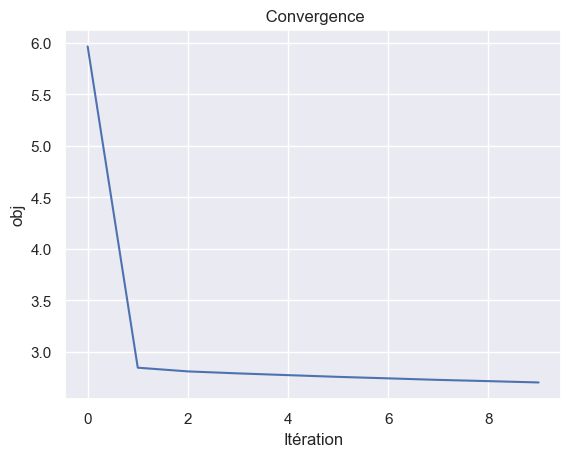

In [37]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
obj = result["obj"]
plt.xlabel('Itération')
plt.ylabel('obj')
plt.title(' Convergence')
plt.plot(np.log(obj))

visualisation des observations dans l'espace des clusters

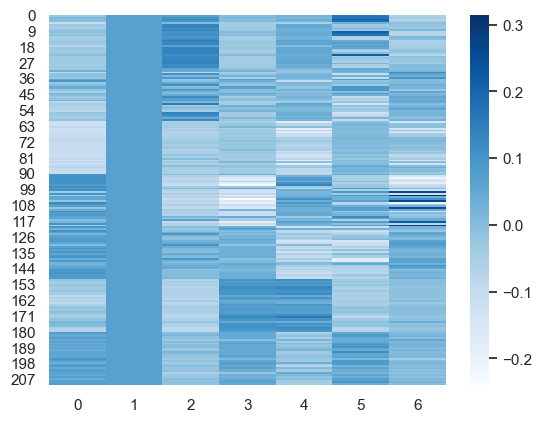

In [38]:
import seaborn as sns; sns.set()
ax = sns.heatmap(result["P"], cmap="Blues")

cacul des métriques

In [39]:
clusteringMeasure(dataset_msrc_v1["Y"], result['labels'])


{'ACC': 0.719047619047619,
 'NMI': 0.6786988930895822,
 'PUR': 0.7523809523809524}

#### experimentations sur toutes les datasets

In [41]:
metrics_me = {"dataset": [], "ACC": [], "NMI": [], "PUR": [], }
for dataset in datasets:
    if dataset["can_use_exp"]:
        print('***** Experimentations sur la dataset {} (en cours)'.format(dataset["name"]))
        
        # recuperation des paramètres pour le modèle
        maxIters = dataset["parameters"]["maxIters"]
        alpha = dataset["parameters"]["alpha"]
        beta = dataset["parameters"]["beta"]
        d = dataset["parameters"]["d"]
        gamma = dataset["parameters"]["gamma"]
        k = dataset["parameters"]["k"]
        
        # execution du modèle en utilisant les paramètres
        result = MCLES(dataset["X"], k, alpha=alpha, beta=beta, d=d, gamma=gamma, maxIters=maxIters)
        
        # construction des clusters
        kmeans = KMeans(
            n_clusters=k,
            n_init='auto'
        )
        kmeans.fit(result["P"])
        labels_clusters = kmeans.labels_
        
        # calcul des métriques
        result = clusteringMeasure(dataset_msrc_v1["Y"], labels_clusters)
        metrics_me["dataset"] = dataset["name"]
        metrics_me["ACC"].append(result["ACC"])
        metrics_me["NMI"].append(result["NMI"])
        metrics_me["PUR"].append(result["PUR"])
        print("fin\n")


***** Experimentations sur la dataset MSRC-v1 (en cours)


/home/mbe/anaconda3/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


fin



In [40]:
metrics_me = pd.DataFrame(metrics_me)
metrics_me.to_json("metrics_me.json")
metrics_me

,dataset,ACC,NMI,PUR
0,MSRC-v1,0.552381,0.56165,0.552381
